TASK 4: EMAIL SPAM DETECTION WITH MACHINE LEARNING

In [54]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

import re

import nltk
from nltk.corpus import stopwords # For stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')  
nltk.download('punkt')       
nltk.download('wordnet')     

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darshit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Darshit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Darshit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
data = pd.read_csv(r"C:\Users\Darshit\OneDrive\Desktop\OIBSIP\Task 4\spam.csv", encoding='latin1')

In [56]:
data.head(10).style.set_table_styles([
    {"selector": "th", "props": [("color", 'black'), ("background-color", "#FF5733"), ('text-align','center')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background', '#DCDCDC')]}, 
    {'selector': 'tr:nth-of-type(even)', 'props': [('background', 'white')]},
])

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",nan,nan,nan
1,ham,Ok lar... Joking wif u oni...,nan,nan,nan
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,nan,nan,nan
3,ham,U dun say so early hor... U c already then say...,nan,nan,nan
4,ham,"Nah I don't think he goes to usf, he lives around here though",nan,nan,nan
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",nan,nan,nan
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.,nan,nan,nan
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,nan,nan,nan
8,spam,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,nan,nan,nan
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,nan,nan,nan


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [58]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [59]:
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [60]:
data.isnull().mean()*100  

v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [61]:
data.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [62]:
data.head(10).style.set_table_styles([
    {"selector": "th", "props": [("color", 'black'), ("background-color", "#a7c5d4"), ('font-weight', 'bold'), ('text-align','center')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background', '#DCDCDC')]}, 
    {'selector': 'tr:nth-of-type(even)', 'props': [('background', 'white')]},
])

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,spam,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [63]:
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head(5).style.set_table_styles([
    {"selector": "th", "props": [("color", 'black'), ("background-color", "#a7c5d4"), ('font-weight', 'bold'), ('text-align','center'),]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background', '#DCDCDC')]}, 
    {'selector': 'tr:nth-of-type(even)', 'props': [('background', 'white')]},
])

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [64]:
data.duplicated().sum()

np.int64(403)

In [65]:
data = data.drop_duplicates(keep = 'first')

In [66]:
data.shape

(5169, 2)

In [67]:
data.describe()

,Target,Text
count,5169,5169
unique,2,5169
top,ham,Rofl. Its true to its name
freq,4516,1


In [68]:
data.groupby('Target').describe().T

Target                              ham  \
Text count                         4516   
     unique                        4516   
     top     Rofl. Its true to its name   
     freq                             1   

Target                                                    spam  
Text count                                                 653  
     unique                                                653  
     top     This is the 2nd time we have tried 2 contact u...  
     freq                                                    1

Text(0, 0.5, 'Number of Data points')

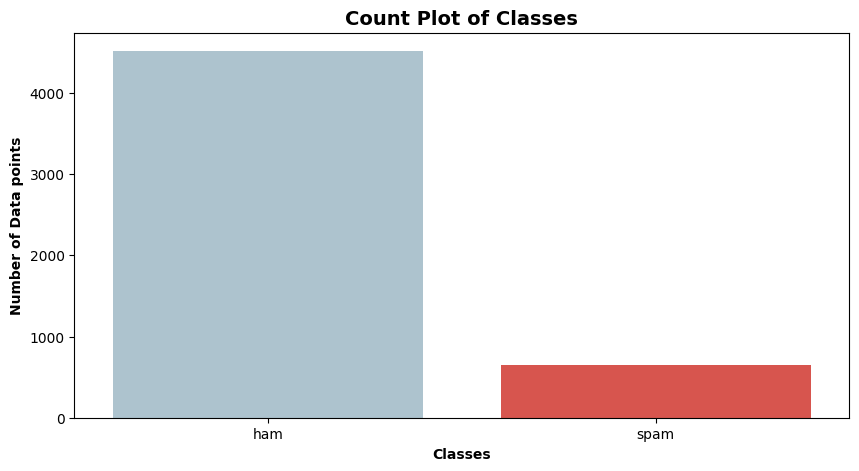

In [69]:
colors= ["#a7c5d4", "#ee4137"] 

plt.figure(figsize=(10,5))
fg = sns.countplot(x= data["Target"], palette= colors)
fg.set_title("Count Plot of Classes", size = 14,fontweight="bold")
fg.set_xlabel("Classes", size = 10,fontweight="bold")
fg.set_ylabel("Number of Data points", size = 10,fontweight="bold")

In [70]:
classes = data['Target'].value_counts()
classes

Target
ham     4516
spam     653
Name: count, dtype: int64

In [71]:
Total = classes.sum()

ham_percentage = (classes['ham'] /Total) * 100
spam_percentage = (classes['spam']/ Total) * 100

print('Percentage of ham :' , ham_percentage.round(2))
print('Percentage of spam :' , spam_percentage.round(2))

Percentage of ham : 87.37
Percentage of spam : 12.63


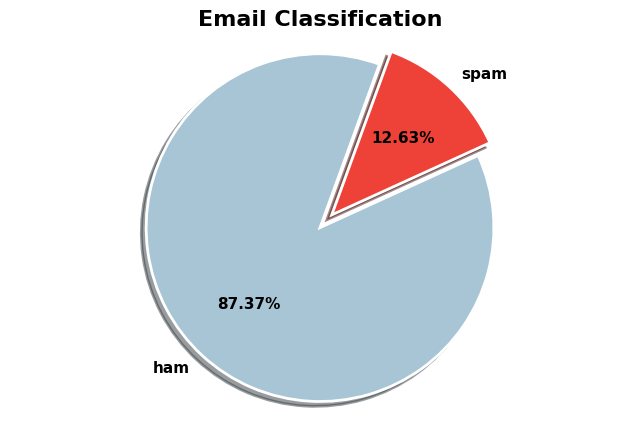

In [72]:
explode = (0, 0.1)  # Explode the second slice (spam) by 10%

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('white')

wedges, texts, autotexts = ax.pie(classes, labels=['ham', 'spam'], autopct='%0.2f%%', startangle= 70, colors=colors,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'}, explode=explode, shadow=True )

for text, autotext in zip(texts, autotexts):
    text.set(size=11, weight='bold')
    autotext.set(size=11, weight='bold')

ax.set_title('Email Classification', fontsize=16, fontweight='bold')

ax.axis('equal')

plt.show()

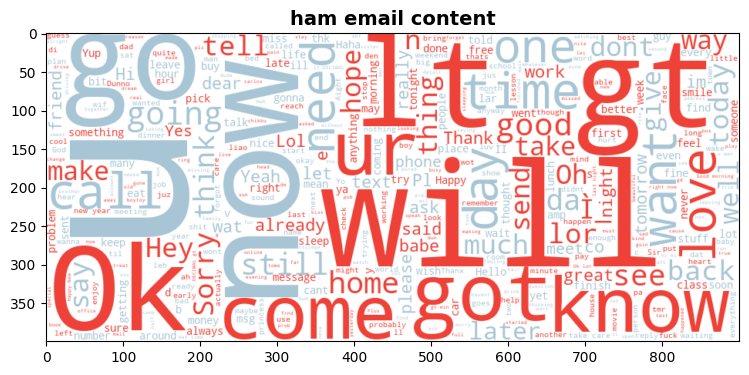

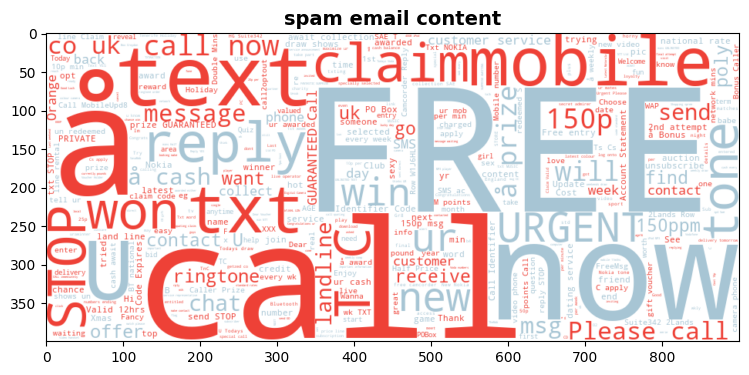

In [73]:
cmap2 = ListedColormap(['#a7c5d4','#ee4137'])

for i in ["ham","spam"]:
    Words= " ".join(data.loc[data['Target'] == i]["Text"])
    plt.figure(figsize=(10,4))
    wordcloud = WordCloud(max_words=400, width=900, height=400, background_color='white', colormap=cmap2).generate(Words)
    plt.imshow(wordcloud , interpolation = "bilinear")
    plt.title(f"{i} email content", size=14, fontweight="bold")
    plt.show()

In [75]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Darshit\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [76]:
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda x: nltk.word_tokenize(x["Text"]), axis=1).apply(len)
data["No_of_Sentences"]=data.apply(lambda x: nltk.sent_tokenize(x["Text"]), axis=1).apply(len)

In [77]:
cmap2 = ListedColormap(['#a7c5d4','#ee4137'])
data.describe().T.style.background_gradient(cmap=cmap2)

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5169.000000,78.977945,58.236293,2.000000,36.000000,60.000000,117.000000,910.000000
No_of_Words,5169.000000,18.455794,13.324758,1.000000,9.000000,15.000000,26.000000,220.000000
No_of_Sentences,5169.000000,1.965564,1.448541,1.000000,1.000000,1.000000,2.000000,38.000000


In [78]:
print(list(data.Text[data.No_of_Characters > 900]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


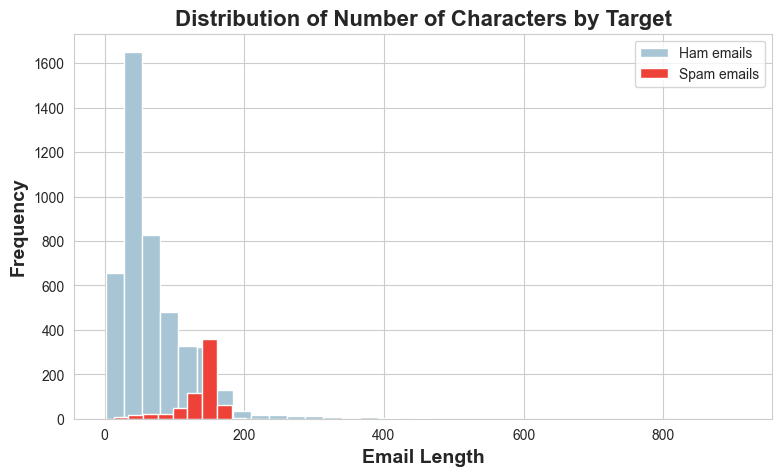

In [79]:
sns.set_style("whitegrid")
plt.figure(figsize=(9, 5))
data[data.Target=='ham'].No_of_Characters.plot(bins=35, kind='hist', color='#a7c5d4', label='Ham emails')
data[data.Target=='spam'].No_of_Characters.plot(kind='hist', color='#ee4137', label='Spam emails')

plt.legend()

plt.title('Distribution of Number of Characters by Target', fontsize=16, fontweight='bold')
plt.xlabel("Email Length",fontsize=14, fontweight='bold')
plt.ylabel("Frequency",fontsize=14, fontweight='bold')

plt.show()

In [80]:
cmap2 = ListedColormap(['#a7c5d4','#ee4137'])
data[data['Target'] == 'ham'][['No_of_Characters', 'No_of_Words', 'No_of_Sentences']].describe().T.style.background_gradient(cmap=cmap2)

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,4516.000000,70.459256,56.358207,2.000000,34.000000,52.000000,90.000000,910.000000
No_of_Words,4516.000000,17.123782,13.493970,1.000000,8.000000,13.000000,22.000000,220.000000
No_of_Sentences,4516.000000,1.820195,1.383657,1.000000,1.000000,1.000000,2.000000,38.000000


In [81]:
data[data['Target'] == 'spam'][['No_of_Characters', 'No_of_Words', 'No_of_Sentences']].describe().T.style.background_gradient(cmap=cmap2)

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,653.000000,137.891271,30.137753,13.000000,132.000000,149.000000,157.000000,224.000000
No_of_Words,653.000000,27.667688,7.008418,2.000000,25.000000,29.000000,32.000000,46.000000
No_of_Sentences,653.000000,2.970904,1.488425,1.000000,2.000000,3.000000,4.000000,9.000000


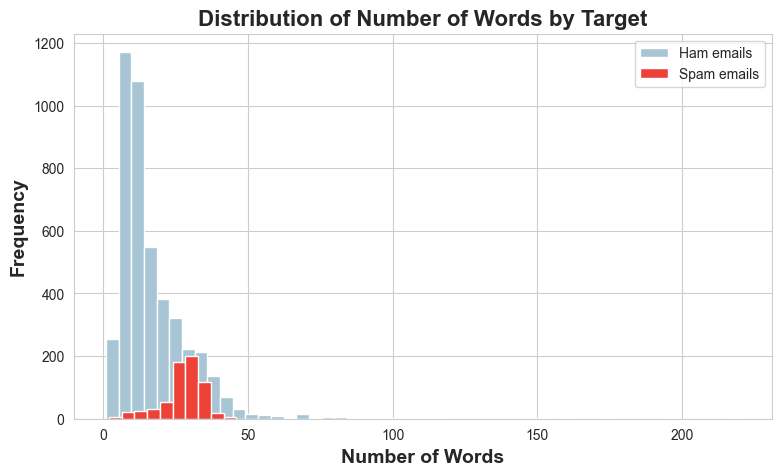

In [82]:
sns.set_style("whitegrid")
plt.figure(figsize=(9, 5))
data[data.Target=='ham'].No_of_Words.plot(bins=50, kind='hist', color='#a7c5d4', label='Ham emails')
data[data.Target=='spam'].No_of_Words.plot(kind='hist', color='#ee4137', label='Spam emails')

plt.legend()

plt.title('Distribution of Number of Words by Target', fontsize=16, fontweight='bold')
plt.xlabel("Number of Words",fontsize=14, fontweight='bold')
plt.ylabel("Frequency",fontsize=14, fontweight='bold')

plt.show()

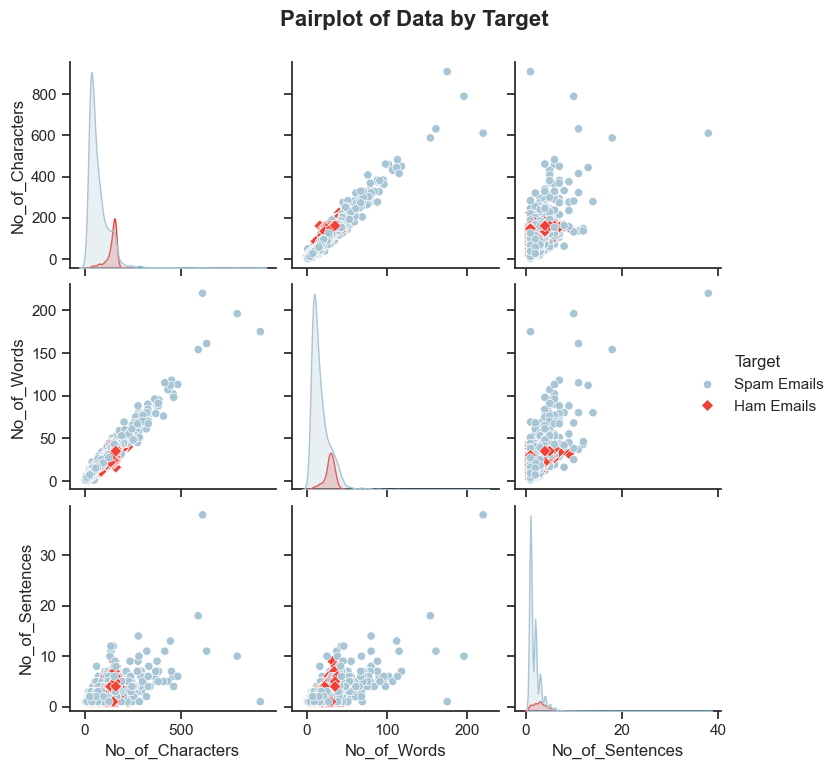

In [83]:
sns.set(style='ticks', color_codes=True)
ax = sns.pairplot(data, hue='Target', diag_kind='kde', markers=["o", "D"], palette=['#a7c5d4','#ee4137'])

ax.fig.suptitle("Pairplot of Data by Target", y=1.02, fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.95) 

ax._legend.set_title('Target')
for t, l in zip(ax._legend.texts, ["Spam Emails", "Ham Emails"]):
    t.set_text(l)

plt.show()

In [84]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['Target'] = encoder.fit_transform(data['Target'])
cmap2 = ListedColormap(['#a7c5d4','#ee4137'])
data[['Target','Text']].head().style.background_gradient(cmap=cmap2)

,Target,Text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


In [85]:
corr_matrix =data[['Target', 'No_of_Characters', 'No_of_Words', 'No_of_Sentences']].corr()
cmap2 = ListedColormap(['#a7c5d4','#ee4137'])
corr_matrix.style.background_gradient(cmap=cmap2)

,Target,No_of_Characters,No_of_Words,No_of_Sentences
Target,1.000000,0.384717,0.262912,0.263939
No_of_Characters,0.384717,1.000000,0.965760,0.624139
No_of_Words,0.262912,0.965760,1.000000,0.679971
No_of_Sentences,0.263939,0.624139,0.679971,1.000000


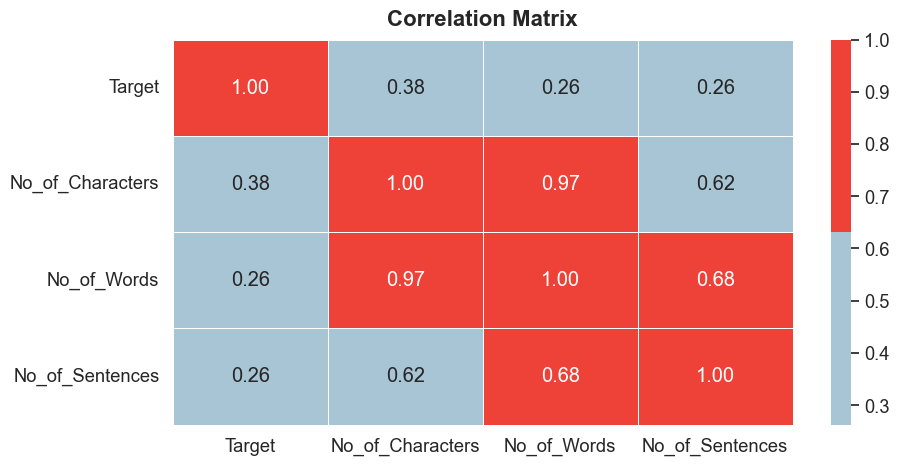

In [86]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,5))
cmap2= ['#a7c5d4','#ee4137']
sns.heatmap(corr_matrix, annot=True, cmap=cmap2, linewidths=0.5, fmt=".2f")

plt.title("Correlation Matrix", fontsize=16, fontweight='bold', pad=10)

plt.show()

In [87]:
data = data[(data["No_of_Characters"]<500)]
data.shape

(5164, 5)

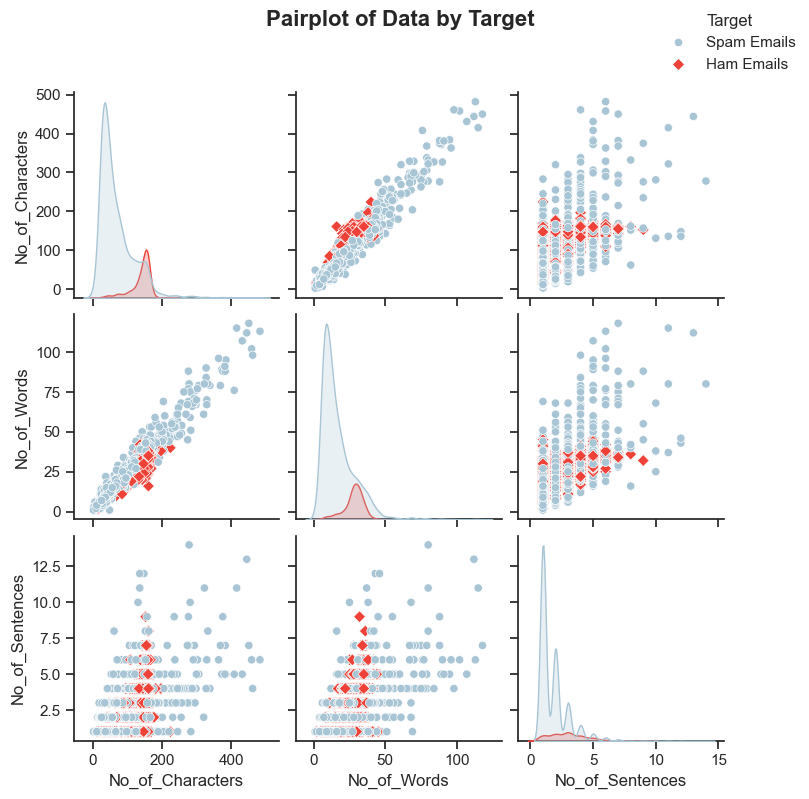

In [88]:
sns.set(style='ticks', color_codes=True)
ax = sns.pairplot(data, hue='Target', diag_kind='kde', markers=["o", "D"], palette=['#a7c5d4','#ee4137'])

ax.fig.suptitle("Pairplot of Data by Target", y=1.06, fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.95)  # Adjust the position of the title

ax._legend.set_title('Target')
for t, l in zip(ax._legend.texts, ["Spam Emails", "Ham Emails"]):
    t.set_text(l)
sns.move_legend (ax, "upper right")

plt.show()

In [89]:
print("\033[31;1;4m Sample of First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")

 Sample of First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [90]:
def Clean(Text):
    email = re.sub('[^a-zA-Z]', ' ', Text) 
    email = email.lower() 
    email = email.split() 
    email = ' '.join(email) 
    return email

data["Clean_Text"] = data["Text"].apply(Clean)

print("\033[31;1;4m Sample of the First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 Sample of the First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [91]:
data[['Text','Clean_Text']].head()

,Text,Clean_Text
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [92]:
data["Tokenized_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)
print("\033[31;1;4m Sample of the First 5 Texts after Tokenizing:\033[0m",*data["Tokenized_Text"][:5], sep = "\n")

 Sample of the First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


In [93]:
data[['Clean_Text','Tokenized_Text']].head()

,Clean_Text,Tokenized_Text
0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,..."


In [94]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["No_Stopword_Text"] = data["Tokenized_Text"].apply(remove_stopwords)

print("\033[31;1;4m Sample of the First 5 Texts after Removing the Stopwords:\033[0m",*data["No_Stopword_Text"][:5], sep = "\n")

 Sample of the First 5 Texts after Removing the Stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


In [95]:
data[['Tokenized_Text','No_Stopword_Text']].head()

,Tokenized_Text,No_Stopword_Text
0,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]"


In [96]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["No_Stopword_Text"].apply(lemmatize_word)
print("\033[31;1;4m The First 5 Texts after Lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after Lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


In [97]:
data[['No_Stopword_Text','Lemmatized_Text']].head()

,No_Stopword_Text,Lemmatized_Text
0,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,"[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


In [98]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_word(text):
    stem = [stemmer.stem(word) for word in text]
    return stem

data["Stemming_Text"] = data["No_Stopword_Text"].apply(stemming_word)
print("\033[31;1;4m The First 5 Texts after Stemming on No_Stopword_Text :\033[0m",*data["Stemming_Text"][:5], sep = "\n")

 The First 5 Texts after Stemming on No_Stopword_Text :
['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entri', 'wkli', 'comp', 'win', 'fa', 'cup', 'final', 'tkt', 'st', 'may', 'text', 'fa', 'receiv', 'entri', 'question', 'std', 'txt', 'rate', 'c', 'appli']
['u', 'dun', 'say', 'earli', 'hor', 'u', 'c', 'alreadi', 'say']
['nah', 'think', 'goe', 'usf', 'live', 'around', 'though']


In [99]:
data[['No_Stopword_Text','Stemming_Text']].head()

,No_Stopword_Text,Stemming_Text
0,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,..."
3,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,"[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]"


In [100]:
stemmer = PorterStemmer()

def stemming_word(text):
    stem = [stemmer.stem(word) for word in text]
    return stem

data["LS_Text"] = data["Lemmatized_Text"].apply(stemming_word)
print("\033[31;1;4m The First 5 Texts after Stemming on Lemmatized_Text :\033[0m",*data["LS_Text"][:5], sep = "\n")

 The First 5 Texts after Stemming on Lemmatized_Text :
['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amor', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entri', 'wkli', 'comp', 'win', 'fa', 'cup', 'final', 'tkt', 'st', 'may', 'text', 'fa', 'receiv', 'entri', 'question', 'std', 'txt', 'rate', 'c', 'appli']
['u', 'dun', 'say', 'earli', 'hor', 'u', 'c', 'alreadi', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


In [101]:
data[['Lemmatized_Text','LS_Text']].head()

,Lemmatized_Text,LS_Text
0,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,"[ok, lar, joke, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,..."
3,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,"[nah, think, go, usf, live, around, though]","[nah, think, go, usf, live, around, though]"


In [102]:
Corpus= []
for i in data["LS_Text"]:
    msg = ' '.join([row for row in i])
    Corpus.append(msg)
    
Corpus[:5]
print("\033[31;1;4m The First 5 lines in corpus:\033[0m",*Corpus[:5], sep = "\n")

 The First 5 lines in corpus:
go jurong point crazi avail bugi n great world la e buffet cine get amor wat
ok lar joke wif u oni
free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli
u dun say earli hor u c alreadi say
nah think go usf live around though


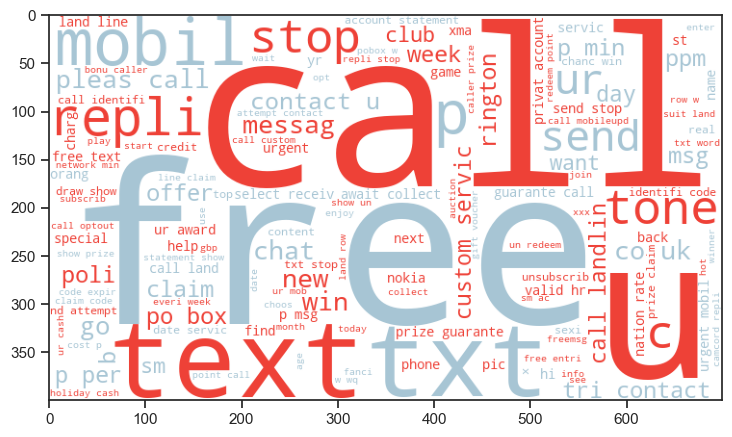

In [103]:
data["Transformed_Text"] = Corpus

cmap2 = ListedColormap(['#a7c5d4','#ee4137'])
plt.figure(figsize = (20,5))
wc = WordCloud(width = 700, height = 400, min_font_size = 10, background_color = 'white',colormap=cmap2)
spam_wc = wc.generate(data[data['Target'] == 1]['Transformed_Text'].str.cat(sep = " "))

plt.imshow(spam_wc)
plt.show()

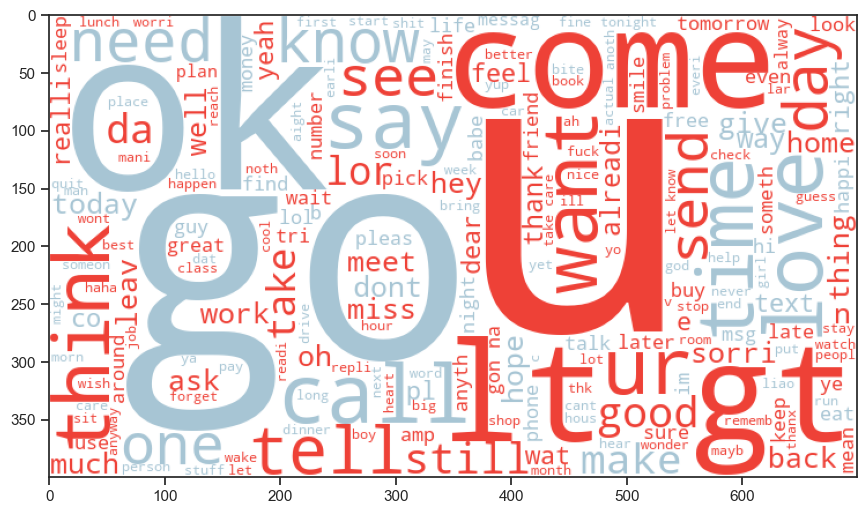

In [104]:
plt.figure(figsize = (15,6))

ham_wc = wc.generate(data[data['Target'] == 0]['Transformed_Text'].str.cat(sep = " "))

plt.imshow(ham_wc)
plt.show()

In [105]:
spam_carpos = []
for sentence in data[data['Target'] == 1]['Transformed_Text'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)

In [106]:
from collections import Counter
filter_spam = pd.DataFrame(Counter(spam_carpos).most_common(30))

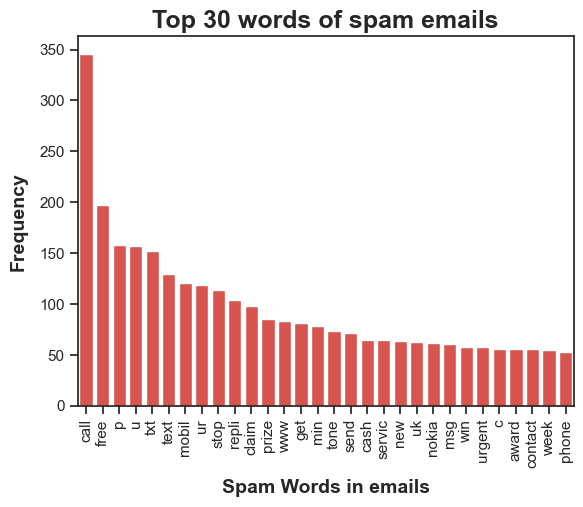

In [107]:
sns.barplot(data = filter_spam, x = filter_spam[0], y = filter_spam[1], color = '#ee4137')
plt.title('Top 30 words of spam emails', fontsize=18, fontweight='bold')
plt.xlabel("Spam Words in emails",fontsize=14, fontweight='bold', labelpad=8)
plt.ylabel("Frequency",fontsize=14, fontweight='bold', labelpad=8)
plt.xticks(rotation = 90)
plt.show()

In [108]:
ham_carpos = []
for sentence in data[data['Target'] == 0]['Transformed_Text'].tolist():
    for word in sentence.split():
        ham_carpos.append(word)

In [109]:
from collections import Counter
filter_ham = pd.DataFrame(Counter(ham_carpos).most_common(30))

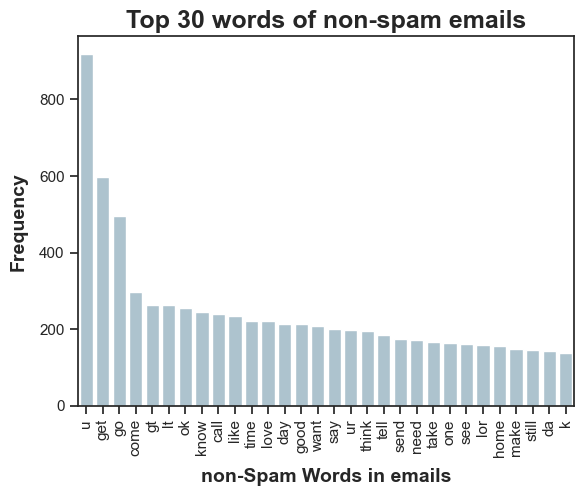

In [110]:
sns.barplot(data = filter_ham, x = filter_ham[0], y = filter_ham[1], color = '#a7c5d4')
plt.title('Top 30 words of non-spam emails', fontsize=18, fontweight='bold')
plt.xlabel("non-Spam Words in emails",fontsize=14, fontweight='bold', labelpad=8)
plt.ylabel("Frequency",fontsize=14, fontweight='bold',labelpad=8)
plt.xticks(rotation = 90)
plt.show()

In [111]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data['Transformed_Text']).toarray()

X.dtype

dtype('float64')

In [112]:
y = data["Target"].astype(int)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
print('Training set shape:', X_train.shape)
print('Testing set shape:', X_test.shape)

Training set shape: (4131, 6098)
Testing set shape: (1033, 6098)


In [115]:
classifiers = [LogisticRegression(solver = 'liblinear', penalty = 'l1'),
               RandomForestClassifier(n_estimators = 50, random_state = 2),
               KNeighborsClassifier(), 
               SVC(kernel= "sigmoid", gamma  = 1.0),
               MultinomialNB(),
               BaggingClassifier(n_estimators = 50, random_state = 2),
               AdaBoostClassifier(n_estimators = 50, random_state = 2),
               GradientBoostingClassifier(n_estimators = 50, random_state = 2),
               XGBClassifier(n_estimators = 50, random_state = 2),
               DecisionTreeClassifier(max_depth = 5)]

for cls in classifiers:
    cls.fit(X_train, y_train)

pipe_dict = {0: "Logistic", 1: "RandomForest", 2: "KNeighbours",3: "SVC", 4: "NaiveBayes", 5: "Bagging", 6: "AdaBoost",
             7: "GradientBoosting", 8: "XGBoost", 9: "DecisionTree"}

In [116]:
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

Logistic: 0.957637 
RandomForest: 0.973128 
KNeighbours: 0.908255 
SVC: 0.977487 
NaiveBayes: 0.961025 
Bagging: 0.967319 
AdaBoost: 0.928588 
GradientBoosting: 0.958362 
XGBoost: 0.975065 
DecisionTree: 0.943113 


In [117]:
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = i.score(X_train,y_train)
    test_accuracy = i.score(X_test,y_test)
  
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [118]:
eval_data = {'Precision':precision, 'Recall':recall, 'F1score':f1_score, 'Accuracy on Trainset':trainset_accuracy,
             'Accuracy on Testset':testset_accuracy}

classifier_model = [cls.__class__.__name__ for cls in classifiers]
Results = pd.DataFrame(eval_data, index=classifier_model)

In [119]:
Results = Results.sort_values(by='Accuracy on Testset')
Results.style.background_gradient(cmap='PuBu')

,Precision,Recall,F1score,Accuracy on Trainset,Accuracy on Testset
KNeighborsClassifier,1.000000,0.314050,0.477987,0.922053,0.919652
AdaBoostClassifier,0.775510,0.628099,0.694064,0.935125,0.935140
DecisionTreeClassifier,0.785047,0.694215,0.736842,0.957879,0.941917
GradientBoostingClassifier,0.946237,0.727273,0.822430,0.972162,0.963214
MultinomialNB,0.988889,0.735537,0.843602,0.971435,0.968054
LogisticRegression,0.941748,0.801653,0.866071,0.966594,0.970958
BaggingClassifier,0.870968,0.892562,0.881633,0.999758,0.971926
RandomForestClassifier,0.980000,0.809917,0.886878,0.999758,0.975799
SVC,0.954128,0.859504,0.904348,0.986444,0.978703
XGBClassifier,0.954128,0.859504,0.904348,0.987896,0.978703


In [120]:
Results['Precision_Rank'] = Results['Precision'].rank(ascending=False)
Results['Recall_Rank'] = Results['Recall'].rank(ascending=False)
Results['F1score_Rank'] = Results['F1score'].rank(ascending=False)
Results['Trainset_Accuracy_Rank'] = Results['Accuracy on Trainset'].rank(ascending=False)
Results['Testset_Accuracy_Rank'] = Results['Accuracy on Testset'].rank(ascending=False)

Results['Overall_Rank'] = Results[['Precision_Rank', 'Recall_Rank', 'F1score_Rank', 'Trainset_Accuracy_Rank', 
                                   'Testset_Accuracy_Rank']].mean(axis=1)

Results['Rank'] = Results['Overall_Rank'].rank(ascending=True, method='first').astype(int)

Results = Results.sort_values(by='Rank')

In [121]:
Results.style.background_gradient(cmap="Reds")

,Precision,Recall,F1score,Accuracy on Trainset,Accuracy on Testset,Precision_Rank,Recall_Rank,F1score_Rank,Trainset_Accuracy_Rank,Testset_Accuracy_Rank,Overall_Rank,Rank
XGBClassifier,0.954128,0.859504,0.904348,0.987896,0.978703,4.500000,2.500000,1.500000,3.000000,1.500000,2.600000,1
SVC,0.954128,0.859504,0.904348,0.986444,0.978703,4.500000,2.500000,1.500000,4.000000,1.500000,2.800000,2
RandomForestClassifier,0.980000,0.809917,0.886878,0.999758,0.975799,3.000000,4.000000,3.000000,1.500000,3.000000,2.900000,3
BaggingClassifier,0.870968,0.892562,0.881633,0.999758,0.971926,8.000000,1.000000,4.000000,1.500000,4.000000,3.700000,4
MultinomialNB,0.988889,0.735537,0.843602,0.971435,0.968054,2.000000,6.000000,6.000000,6.000000,6.000000,5.200000,5
LogisticRegression,0.941748,0.801653,0.866071,0.966594,0.970958,7.000000,5.000000,5.000000,7.000000,5.000000,5.800000,6
GradientBoostingClassifier,0.946237,0.727273,0.822430,0.972162,0.963214,6.000000,7.000000,7.000000,5.000000,7.000000,6.400000,7
KNeighborsClassifier,1.000000,0.314050,0.477987,0.922053,0.919652,1.000000,10.000000,10.000000,10.000000,10.000000,8.200000,8
DecisionTreeClassifier,0.785047,0.694215,0.736842,0.957879,0.941917,9.000000,8.000000,8.000000,8.000000,8.000000,8.200000,9
AdaBoostClassifier,0.775510,0.628099,0.694064,0.935125,0.935140,10.000000,9.000000,9.000000,9.000000,9.000000,9.200000,10


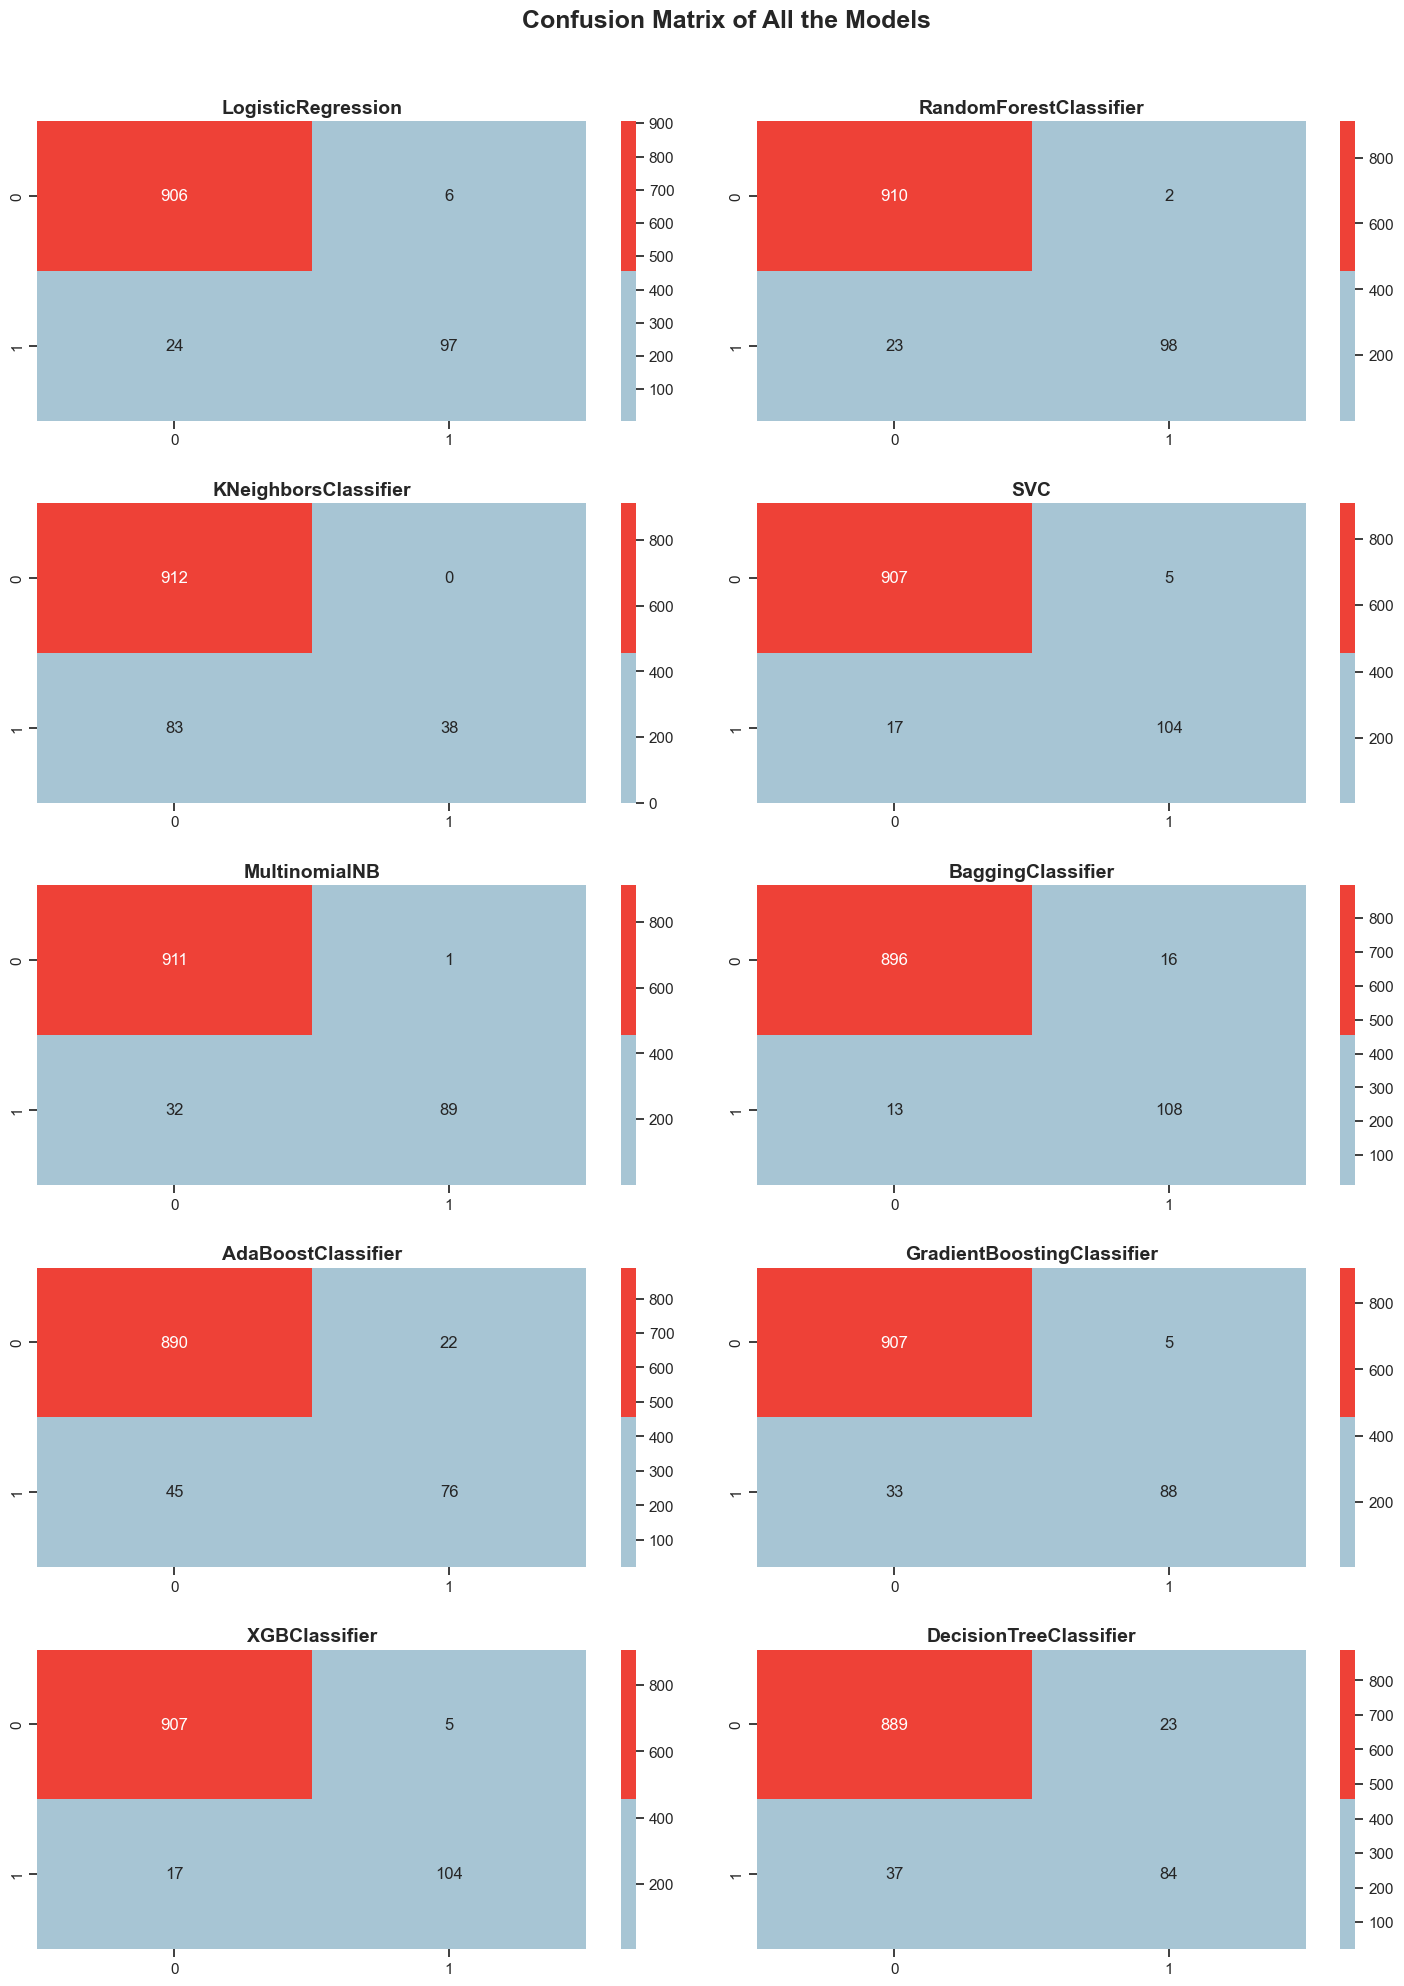

In [122]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,20))

for cls, ax in zip(classifiers, axes.flatten()):
    y_pred = cls.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=cmap2)
    ax.set_title(type(cls).__name__,fontsize=14, fontweight='bold')

plt.suptitle('Confusion Matrix of All the Models', size = 18, fontweight = 'bold', y=1)
plt.tight_layout(pad = 2.0)
plt.show()

In [123]:
best_model = Results['Rank'].idxmin()
Best_Model = [cls for cls in classifiers if cls.__class__.__name__ == best_model][0]

print("Best Model is:", Best_Model)

Best Model is: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)
